In [57]:
#import
import numpy as np
import matplotlib.pyplot as plt
import math as mh 
import pandas as pd
from tqdm import tqdm
import os
#import NEATM
from NEATM2 import *
#constant
Fsun = 1367.5           # sun constant
sigma = 5.67E-8         #stefan-boltzmann constant
h = 6.626007015E-34     #plank constant
#q = 0.29+0.684*0.15    #phase integral = 0.29+0.684*G(=0.15)
epsi = 0.9             #radiance epsilon
kB = 1.38064852E-23     #boltzmann constant  j/k
cl = 299792458.0        #lightspeed m/s
au = 149597870700.0
pi = 3.1415926535
Rsun = 0.00465*au   #Rsun *m
Tsun = 5778         #Tsun  K
Hv = 21.4
G = 0.15
Ndd = 15
lamdai = [4.6,12,22]

### load epoch & cal epoch , define "x"

In [58]:
name = '2010DG77'
#df = pd.read_table(f'ws.dat.{name}')
ast = np.loadtxt(f'ws.dat.{name}',skiprows=1,usecols=(5,6,7))
ear = np.loadtxt(f'ws.dat.{name}',skiprows=1,usecols=(8,9,10))
#ast-sun
d_N = np.sqrt(ast[:,0]**2+ast[:,1]**2+ast[:,2]**2)
#print('ast-sun',d_N)
#ast-earth
delta_N = np.sqrt((ast[:,0]-ear[:,0])**2+(ast[:,1]-ear[:,1])**2+(ast[:,2]-ear[:,2])**2)
#print('ast-earth',delta_N)
#earth-sun
dd_N = np.sqrt(ear[:,0]**2+ear[:,1]**2+ear[:,2]**2)
#print('earth-sun',dd_N)
#alpha
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
x = (delta_N,d_N,alpha_N)

### load obs data , define "y"

In [59]:
time = np.loadtxt(f'mba.jd.{name}')
mjdtime = time-2400000.5
obsdat = np.loadtxt(f'obsNEW.txt.{name}')
n4 = len(obsdat)//4
w1 = obsdat[:n4]
w2 = obsdat[n4:2*n4]
w3 = obsdat[2*n4:n4*3]
w4 = obsdat[n4*3:]
'''plt.subplot(2,1,1)
plt.plot(mjdtime[:n3//2+5],w2[:n3//2+5],'bo',label='w2')
plt.plot(mjdtime[:n3//2+5],w3[:n3//2+5],'yo',label='w3')
plt.plot(mjdtime[:n3//2+5],w4[:n3//2+5],'ro',label='w4')
plt.subplot(2,1,2)
plt.plot(mjdtime[n3//2+5:],w2[n3//2+5:],'bo',label='w2')
plt.plot(mjdtime[n3//2+5:],w3[n3//2+5:],'yo',label='w3')
plt.plot(mjdtime[n3//2+5:],w4[n3//2+5:],'ro',label='w4')
plt.legend()'''
y = obsdat

## model

In [60]:
def Model_neatm_Ref_jhx(theta,x,lamda):
    '''
    theta = (eta,D,wf)
    x = (astp,obsp)
    x = (3.4x;4.6x;12x;22x)
    '''
    eta,D,wf  = theta
    astp,obsp = x
    lamda2,lamda3,lamda4 = lamda
    #print('k',astp)
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    flux = np.zeros(n4*4)
    for i in range(n4):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,3.4,eta,A,Hv)
        flux[i] = 1.3917*fluxi + 1.0049*(wf*frLambi + frLommi)
        #print(f'{i}:ast{astp[i]} obs{obsp[i]} flux {flux[i]}')
    for i in range(n4,2*n4):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,lamda2,eta,A,Hv)
        flux[i] = 1.1124*fluxi + 1.0193*(wf*frLambi + frLommi)
        #print(f'{i}:ast{astp[i]} obs{obsp[i]} flux {flux[i]}')
    for i in range(2*n4,n4*3):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,lamda3,eta,A,Hv)
        flux[i] = 0.8791*fluxi 
        #print(f'{i}:ast{astp[i]} obs{obsp[i]} flux {flux[i]}')
    for i in range(n4*3,n4*4):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,lamda4,eta,A,Hv)
        flux[i] = 0.9865*fluxi     
       # print(f'{i}:ast{astp[i]} obs{obsp[i]} flux {flux[i]}')
    return flux    

### cal flux with ref

/home/astrohhq/learngit/newwisedata/test4/NEATM2.py:188: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


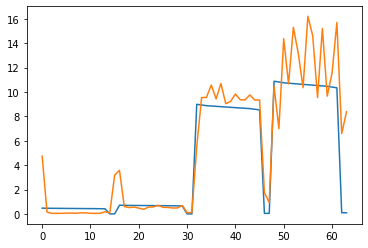

In [61]:
xast = np.vstack((ast,ast,ast,ast))
xear  =  np.vstack((ear,ear,ear,ear))
xt = (xast,xear)
flux = Model_neatm_Ref_jhx((1.5,115,0.5),xt,(4.6,12,22))
plt.plot(flux)
plt.plot(y)

## MCMC

In [62]:
#initial
eta_gs = 1.5
D_gs = 115
eta_gss = [0.1,3,0.05]
D_gss = [50,300,2]
wf_gs = 0.5
wf_gss = [0.01,1,0.1]
logf_gs = 0.4
logf_gss = [-10,1]

In [63]:
#initial para guesses
eta = eta_gs
D = D_gs
wf = wf_gs
logf = logf_gs
test = [eta, D,wf]

In [64]:
def loss(obs,cal,err):
    l = len(obs)
    return sum(((obs-cal)/err)**2)/l
print('LossFunction = ',loss(y,Model_neatm_Ref_jhx(test,xt,lamdai),1))


LossFunction =  5.240247696197105


/home/astrohhq/learngit/newwisedata/test4/NEATM2.py:188: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


In [66]:
n_eta = int((eta_gss[1]-eta_gss[0])/eta_gss[2]+1)                     
n_D = int((D_gss[1]-D_gss[0])/D_gss[2]+1)
n_wf = int((wf_gss[1]-wf_gss[0])/wf_gss[2]+1)
Ntime = n_eta*n_D*n_wf         
print(f'It`s need {Ntime} setps',f'eta={n_eta} d={n_D}')

minloss = 10e6
nstep = 0
Di = D_gss[0]
for i in tqdm(range(n_D)):
    etai = eta_gss[0]
    for j in tqdm(range(n_eta), leave=False):
        wfi = wf_gss[0]
        for k in range(n_wf):
            flux = np.zeros(n4*4)
            testi = [etai,Di,wfi]
            flux = Model_neatm_Ref_jhx(testi,xt,lamdai)
            lossi = loss(y,1,flux)
            if lossi<minloss :
                minloss = lossi
                eta_fit = etai
                D_fit  = Di
                wf_fit  = wfi
                print(f'step {nstep} :loss = {lossi} eta = {eta_fit} D = {D_fit} wf = {wf_fit}')
            wfi = wfi + wf_gss[2]
            nstep = nstep + 1
        etai = etai + eta_gss[2]
    Di = Di + D_gss[2]


It`s need 73080 setps eta=58 d=126


  0%|          | 0/126 [00:00<?, ?it/s]

step 0 :loss = 185547.07467094527 eta = 0.1 D = 50 wf = 0.01
step 1 :loss = 162094.62752078203 eta = 0.1 D = 50 wf = 0.11
step 2 :loss = 142879.4748306708 eta = 0.1 D = 50 wf = 0.21000000000000002

/home/astrohhq/learngit/newwisedata/test4/NEATM2.py:188: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy



step 3 :loss = 126937.5275255282 eta = 0.1 D = 50 wf = 0.31000000000000005
step 4 :loss = 113564.14018693818 eta = 0.1 D = 50 wf = 0.41000000000000003
step 5 :loss = 102234.62134110945 eta = 0.1 D = 50 wf = 0.51
step 6 :loss = 92551.77191141929 eta = 0.1 D = 50 wf = 0.61
step 7 :loss = 84210.43709073211 eta = 0.1 D = 50 wf = 0.71


step 8 :loss = 76973.04607186787 eta = 0.1 D = 50 wf = 0.8099999999999999
step 9 :loss = 70652.41276103763 eta = 0.1 D = 50 wf = 0.9099999999999999


  1%|          | 1/126 [00:47<1:38:19, 47.19s/it]


step 582 :loss = 68804.23337876421 eta = 0.1 D = 52 wf = 0.21000000000000002
step 583 :loss = 63308.482052282154 eta = 0.1 D = 52 wf = 0.31000000000000005
step 584 :loss = 58455.759518196624 eta = 0.1 D = 52 wf = 0.41000000000000003
step 585 :loss = 54149.388476697255 eta = 0.1 D = 52 wf = 0.51
step 586 :loss = 50310.204245317356 eta = 0.1 D = 52 wf = 0.61
step 587 :loss = 46872.881304038085 eta = 0.1 D = 52 wf = 0.71
step 588 :loss = 43783.128368674326 eta = 0.1 D = 52 wf = 0.8099999999999999
step 589 :loss = 40995.52499470508 eta = 0.1 D = 52 wf = 0.9099999999999999


  2%|▏         | 2/126 [01:34<1:37:38, 47.25s/it]

step 1160 :loss = 38696.52352209631 eta = 0.1 D = 54 wf = 0.01
step 1161 :loss = 36339.93885516929 eta = 0.1 D = 54 wf = 0.11
step 1162 :loss = 34195.56927985385 eta = 0.1 D = 54 wf = 0.21000000000000002
step 1163 :loss = 32238.65200259593 eta = 0.1 D = 54 wf = 0.31000000000000005
step 1164 :loss = 30447.934008433327 eta = 0.1 D = 54 wf = 0.41000000000000003


  3%|▎         | 2/58 [00:01<00:44,  1.25it/s]


step 1165 :loss = 28805.091585143906 eta = 0.1 D = 54 wf = 0.51
step 1166 :loss = 27294.258841558916 eta = 0.1 D = 54 wf = 0.61
step 1167 :loss = 25901.642443087552 eta = 0.1 D = 54 wf = 0.71
step 1168 :loss = 24615.20500569022 eta = 0.1 D = 54 wf = 0.8099999999999999
step 1169 :loss = 23424.403512446697 eta = 0.1 D = 54 wf = 0.9099999999999999


  2%|▏         | 3/126 [02:20<1:35:19, 46.50s/it]

step 1740 :loss = 19945.89118953477 eta = 0.1 D = 56 wf = 0.01
step 1741 :loss = 19067.04740319562 eta = 0.1 D = 56 wf = 0.11
step 1742 :loss = 18246.157586925172 eta = 0.1 D = 56 wf = 0.21000000000000002
step 1743 :loss = 17478.23045842391 eta = 0.1 D = 56 wf = 0.31000000000000005
step 1744 :loss = 16758.800811059453 eta = 0.1 D = 56 wf = 0.41000000000000003
step 1745 :loss = 16083.864350865731 eta = 0.1 D = 56 wf = 0.51
step 1746 :loss = 15449.82175957084 eta = 0.1 D = 56 wf = 0.61
step 1747 :loss = 14853.430520425509 eta = 0.1 D = 56 wf = 0.71
step 1748 :loss = 14291.7632995952 eta = 0.1 D = 56 wf = 0.8099999999999999
step 1749 :loss = 13762.17188305813 eta = 0.1 D = 56 wf = 0.9099999999999999


  3%|▎         | 4/126 [03:05<1:33:40, 46.07s/it]

step 2320 :loss = 11211.099420391336 eta = 0.1 D = 58 wf = 0.01
step 2321 :loss = 10840.278918647089 eta = 0.1 D = 58 wf = 0.11
step 2322 :loss = 10488.00349434496 eta = 0.1 D = 58 wf = 0.21000000000000002
step 2323 :loss = 10153.055419816841 eta = 0.1 D = 58 wf = 0.31000000000000005
step 2324 :loss = 9834.315316499462 eta = 0.1 D = 58 wf = 0.41000000000000003
step 2325 :loss = 9530.752774668435 eta = 0.1 D = 58 wf = 0.51
step 2326 :loss = 9241.418000601938 eta = 0.1 D = 58 wf = 0.61
step 2327 :loss = 8965.434364545292 eta = 0.1 D = 58 wf = 0.71
step 2328 :loss = 8701.991740138887 eta = 0.1 D = 58 wf = 0.8099999999999999
step 2329 :loss = 8450.34054067842 eta = 0.1 D = 58 wf = 0.9099999999999999


  4%|▍         | 5/126 [03:51<1:32:40, 45.96s/it]

step 2900 :loss = 6783.209850011449 eta = 0.1 D = 60 wf = 0.01
step 2901 :loss = 6609.171179459832 eta = 0.1 D = 60 wf = 0.11
step 2902 :loss = 6441.9467071976915 eta = 0.1 D = 60 wf = 0.21000000000000002
step 2903 :loss = 6281.184849003175 eta = 0.1 D = 60 wf = 0.31000000000000005
step 2904 :loss = 6126.556410843123 eta = 0.1 D = 60 wf = 0.41000000000000003
step 2905 :loss = 5977.752899297572 eta = 0.1 D = 60 wf = 0.51
step 2906 :loss = 5834.484978881808 eta = 0.1 D = 60 wf = 0.61
step 2907 :loss = 5696.481061848815 eta = 0.1 D = 60 wf = 0.71
step 2908 :loss = 5563.4860176274815 eta = 0.1 D = 60 wf = 0.8099999999999999
step 2909 :loss = 5435.259990436152 eta = 0.1 D = 60 wf = 0.9099999999999999

  5%|▍         | 6/126 [04:36<1:31:41, 45.84s/it]

step 3480 :loss = 4360.991496782704 eta = 0.1 D = 62 wf = 0.01
step 3481 :loss = 4271.757289290915 eta = 0.1 D = 62 wf = 0.11
step 3482 :loss = 4185.333800423625 eta = 0.1 D = 62 wf = 0.21000000000000002
step 3483 :loss = 4101.604057268067 eta = 0.1 D = 62 wf = 0.31000000000000005
step 3484 :loss = 4020.4571103837757 eta = 0.1 D = 62 wf = 0.41000000000000003
step 3485 :loss = 3941.7876653769886 eta = 0.1 D = 62 wf = 0.51
step 3486 :loss = 3865.4957405002724 eta = 0.1 D = 62 wf = 0.61
step 3487 :loss = 3791.4863481973935 eta = 0.1 D = 62 wf = 0.71


  3%|▎         | 2/58 [00:01<00:46,  1.20it/s]


step 3488 :loss = 3719.66919869855 eta = 0.1 D = 62 wf = 0.8099999999999999
step 3489 :loss = 3649.958423938125 eta = 0.1 D = 62 wf = 0.9099999999999999


  6%|▌         | 7/126 [05:22<1:30:50, 45.80s/it]


step 4060 :loss = 2946.779890255743 eta = 0.1 D = 64 wf = 0.01
step 4061 :loss = 2897.5666298332935 eta = 0.1 D = 64 wf = 0.11
step 4062 :loss = 2849.629242256421 eta = 0.1 D = 64 wf = 0.21000000000000002
step 4063 :loss = 2802.923939627965 eta = 0.1 D = 64 wf = 0.31000000000000005
step 4064 :loss = 2757.4087969425636 eta = 0.1 D = 64 wf = 0.41000000000000003
step 4065 :loss = 2713.043657781567 eta = 0.1 D = 64 wf = 0.51
step 4066 :loss = 2669.790045531043 eta = 0.1 D = 64 wf = 0.61
step 4067 :loss = 2627.611079756266 eta = 0.1 D = 64 wf = 0.71
step 4068 :loss = 2586.4713973932403 eta = 0.1 D = 64 wf = 0.8099999999999999
step 4069 :loss = 2546.3370784427107 eta = 0.1 D = 64 wf = 0.9099999999999999


  6%|▋         | 8/126 [06:10<1:31:18, 46.43s/it]

step 4640 :loss = 2074.489893334177 eta = 0.1 D = 66 wf = 0.01
step 4641 :loss = 2045.6603701928302 eta = 0.1 D = 66 wf = 0.11
step 4642 :loss = 2017.4579186650008 eta = 0.1 D = 66 wf = 0.21000000000000002
step 4643 :loss = 1989.8644563196349 eta = 0.1 D = 66 wf = 0.31000000000000005
step 4644 :loss = 1962.8625479905122 eta = 0.1 D = 66 wf = 0.41000000000000003
step 4645 :loss = 1936.435378170161 eta = 0.1 D = 66 wf = 0.51
step 4646 :loss = 1910.5667247677397 eta = 0.1 D = 66 wf = 0.61
step 4647 :loss = 1885.2409341543914 eta = 0.1 D = 66 wf = 0.71
step 4648 :loss = 1860.4428974243929 eta = 0.1 D = 66 wf = 0.8099999999999999
step 4649 :loss = 1836.158027804871 eta = 0.1 D = 66 wf = 0.9099999999999999


  7%|▋         | 9/126 [06:56<1:30:23, 46.36s/it]


step 5220 :loss = 1510.9826401150215 eta = 0.1 D = 68 wf = 0.01
step 5221 :loss = 1493.2223636230888 eta = 0.1 D = 68 wf = 0.11
step 5222 :loss = 1475.7914555984114 eta = 0.1 D = 68 wf = 0.21000000000000002
step 5223 :loss = 1458.6818088100174 eta = 0.1 D = 68 wf = 0.31000000000000005
step 5224 :loss = 1441.885564003992 eta = 0.1 D = 68 wf = 0.41000000000000003
step 5225 :loss = 1425.3951008565953 eta = 0.1 D = 68 wf = 0.51
step 5226 :loss = 1409.2030293101175 eta = 0.1 D = 68 wf = 0.61
step 5227 :loss = 1393.302181273078 eta = 0.1 D = 68 wf = 0.71
step 5228 :loss = 1377.6856026673615 eta = 0.1 D = 68 wf = 0.8099999999999999
step 5229 :loss = 1362.3465458058283 eta = 0.1 D = 68 wf = 0.9099999999999999


  8%|▊         | 10/126 [07:43<1:29:55, 46.52s/it]

step 5800 :loss = 1132.4088990175935 eta = 0.1 D = 70 wf = 0.01
step 5801 :loss = 1120.9942589657667 eta = 0.1 D = 70 wf = 0.11
step 5802 :loss = 1109.7625880881221 eta = 0.1 D = 70 wf = 0.21000000000000002
step 5803 :loss = 1098.7099901123897 eta = 0.1 D = 70 wf = 0.31000000000000005
step 5804 :loss = 1087.8326719556112 eta = 0.1 D = 70 wf = 0.41000000000000003
step 5805 :loss = 1077.126940461834 eta = 0.1 D = 70 wf = 0.51


step 5806 :loss = 1066.589199259501 eta = 0.1 D = 70 wf = 0.61
step 5807 :loss = 1056.2159457335447 eta = 0.1 D = 70 wf = 0.71
step 5808 :loss = 1046.0037681074268 eta = 0.1 D = 70 wf = 0.8099999999999999
step 5809 :loss = 1035.9493426305812 eta = 0.1 D = 70 wf = 0.9099999999999999


  9%|▊         | 11/126 [08:29<1:28:58, 46.42s/it]

step 6380 :loss = 869.4389728100708 eta = 0.1 D = 72 wf = 0.01
step 6381 :loss = 861.8337538786004 eta = 0.1 D = 72 wf = 0.11
step 6382 :loss = 854.3351397378473 eta = 0.1 D = 72 wf = 0.21000000000000002
step 6383 :loss = 846.9411437416622 eta = 0.1 D = 72 wf = 0.31000000000000005
step 6384 :loss = 839.6498253196578 eta = 0.1 D = 72 wf = 0.41000000000000003
step 6385 :loss = 832.4592887007242 eta = 0.1 D = 72 wf = 0.51


  3%|▎         | 2/58 [00:01<00:43,  1.28it/s]


step 6386 :loss = 825.3676816776167 eta = 0.1 D = 72 wf = 0.61
step 6387 :loss = 818.3731944111036 eta = 0.1 D = 72 wf = 0.71
step 6388 :loss = 811.4740582722426 eta = 0.1 D = 72 wf = 0.8099999999999999
step 6389 :loss = 804.6685447213952 eta = 0.1 D = 72 wf = 0.9099999999999999


 10%|▉         | 12/126 [09:16<1:28:21, 46.50s/it]

step 6960 :loss = 681.4547657266984 eta = 0.1 D = 74 wf = 0.01
step 6961 :loss = 676.2287446521046 eta = 0.1 D = 74 wf = 0.11
step 6962 :loss = 671.067429974215 eta = 0.1 D = 74 wf = 0.21000000000000002
step 6963 :loss = 665.9697559090656 eta = 0.1 D = 74 wf = 0.31000000000000005
step 6964 :loss = 660.9346785321769 eta = 0.1 D = 74 wf = 0.41000000000000003
step 6965 :loss = 655.961175242711 eta = 0.1 D = 74 wf = 0.51
step 6966 :loss = 651.0482442428981 eta = 0.1 D = 74 wf = 0.61
step 6967 :loss = 646.1949040322247 eta = 0.1 D = 74 wf = 0.71


step 6968 :loss = 641.4001929159131 eta = 0.1 D = 74 wf = 0.8099999999999999
step 6969 :loss = 636.6631685272338 eta = 0.1 D = 74 wf = 0.9099999999999999


 10%|█         | 13/126 [10:04<1:28:22, 46.93s/it]


step 7540 :loss = 543.6958434628501 eta = 0.1 D = 76 wf = 0.01
step 7541 :loss = 540.0075199438412 eta = 0.1 D = 76 wf = 0.11
step 7542 :loss = 536.3598876471549 eta = 0.1 D = 76 wf = 0.21000000000000002
step 7543 :loss = 532.7523490666579 eta = 0.1 D = 76 wf = 0.31000000000000005
step 7544 :loss = 529.1843176265215 eta = 0.1 D = 76 wf = 0.41000000000000003
step 7545 :loss = 525.6552174421431 eta = 0.1 D = 76 wf = 0.51
step 7546 :loss = 522.164483087148 eta = 0.1 D = 76 wf = 0.61
step 7547 :loss = 518.7115593662924 eta = 0.1 D = 76 wf = 0.71
step 7548 :loss = 515.2959010941001 eta = 0.1 D = 76 wf = 0.8099999999999999
step 7549 :loss = 511.91697287906703 eta = 0.1 D = 76 wf = 0.9099999999999999


 11%|█         | 14/126 [10:53<1:29:10, 47.77s/it]

step 8120 :loss = 440.5345208259789 eta = 0.1 D = 78 wf = 0.01
step 8121 :loss = 437.87013005575176 eta = 0.1 D = 78 wf = 0.11
step 8122 :loss = 435.2321313394846 eta = 0.1 D = 78 wf = 0.21000000000000002
step 8123 :loss = 432.62017657352345 eta = 0.1 D = 78 wf = 0.31000000000000005


step 8124 :loss = 430.03392337637166 eta = 0.1 D = 78 wf = 0.41000000000000003
step 8125 :loss = 427.4730349761798 eta = 0.1 D = 78 wf = 0.51
step 8126 :loss = 424.93718010080966 eta = 0.1 D = 78 wf = 0.61
step 8127 :loss = 422.4260328704009 eta = 0.1 D = 78 wf = 0.71
step 8128 :loss = 419.9392726923817 eta = 0.1 D = 78 wf = 0.8099999999999999
step 8129 :loss = 417.4765841588525 eta = 0.1 D = 78 wf = 0.9099999999999999


 12%|█▏        | 15/126 [11:41<1:28:23, 47.78s/it]

step 8700 :loss = 361.80071951173335 eta = 0.1 D = 80 wf = 0.01
step 8701 :loss = 359.83624884667626 eta = 0.1 D = 80 wf = 0.11
step 8702 :loss = 357.88936694546675 eta = 0.1 D = 80 wf = 0.21000000000000002
step 8703 :loss = 355.95986403561557 eta = 0.1 D = 80 wf = 0.31000000000000005
step 8704 :loss = 354.0475334636664 eta = 0.1 D = 80 wf = 0.41000000000000003
step 8705 :loss = 352.1521716397066 eta = 0.1 D = 80 wf = 0.51
step 8706 :loss = 350.27357798302535 eta = 0.1 D = 80 wf = 0.61


step 8707 :loss = 348.4115548688955 eta = 0.1 D = 80 wf = 0.71
step 8708 :loss = 346.5659075764484 eta = 0.1 D = 80 wf = 0.8099999999999999
step 8709 :loss = 344.73644423761914 eta = 0.1 D = 80 wf = 0.9099999999999999


 13%|█▎        | 16/126 [12:30<1:28:13, 48.13s/it]

step 9280 :loss = 300.6942301225766 eta = 0.1 D = 82 wf = 0.01
step 9281 :loss = 299.21940012346806 eta = 0.1 D = 82 wf = 0.11
step 9282 :loss = 297.75657683812994 eta = 0.1 D = 82 wf = 0.21000000000000002
step 9283 :loss = 296.30563001846434 eta = 0.1 D = 82 wf = 0.31000000000000005
step 9284 :loss = 294.86643117834427 eta = 0.1 D = 82 wf = 0.41000000000000003
step 9285 :loss = 293.43885356508787 eta = 0.1 D = 82 wf = 0.51


  3%|▎         | 2/58 [00:01<00:48,  1.16it/s]


step 9286 :loss = 292.0227721314664 eta = 0.1 D = 82 wf = 0.61
step 9287 :loss = 290.6180635082424 eta = 0.1 D = 82 wf = 0.71
step 9288 :loss = 289.2246059772191 eta = 0.1 D = 82 wf = 0.8099999999999999
step 9289 :loss = 287.84227944479505 eta = 0.1 D = 82 wf = 0.9099999999999999


 13%|█▎        | 17/126 [13:19<1:27:34, 48.20s/it]

step 9860 :loss = 252.55711004150334 eta = 0.1 D = 84 wf = 0.01
step 9861 :loss = 251.43193683218544 eta = 0.1 D = 84 wf = 0.11
step 9862 :loss = 250.315136802396 eta = 0.1 D = 84 wf = 0.21000000000000002
step 9863 :loss = 249.20662690009993 eta = 0.1 D = 84 wf = 0.31000000000000005
step 9864 :loss = 248.10632510079577 eta = 0.1 D = 84 wf = 0.41000000000000003
step 9865 :loss = 247.01415039229704 eta = 0.1 D = 84 wf = 0.51
step 9866 :loss = 245.93002275977577 eta = 0.1 D = 84 wf = 0.61
step 9867 :loss = 244.85386317106344 eta = 0.1 D = 84 wf = 0.71
step 9868 :loss = 243.78559356220396 eta = 0.1 D = 84 wf = 0.8099999999999999
step 9869 :loss = 242.72513682325396 eta = 0.1 D = 84 wf = 0.9099999999999999


 14%|█▍        | 18/126 [14:08<1:27:13, 48.46s/it]

step 10440 :loss = 214.12922846167066 eta = 0.1 D = 86 wf = 0.01
step 10441 :loss = 213.2583830489854 eta = 0.1 D = 86 wf = 0.11
step 10442 :loss = 212.39348956395295 eta = 0.1 D = 86 wf = 0.21000000000000002
step 10443 :loss = 211.5344937725054 eta = 0.1 D = 86 wf = 0.31000000000000005
step 10444 :loss = 210.68134205712045 eta = 0.1 D = 86 wf = 0.41000000000000003


step 10445 :loss = 209.83398140842812 eta = 0.1 D = 86 wf = 0.51
step 10446 :loss = 208.99235941695173 eta = 0.1 D = 86 wf = 0.61
step 10447 :loss = 208.15642426497953 eta = 0.1 D = 86 wf = 0.71
step 10448 :loss = 207.32612471856356 eta = 0.1 D = 86 wf = 0.8099999999999999
step 10449 :loss = 206.5014101196458 eta = 0.1 D = 86 wf = 0.9099999999999999


 15%|█▌        | 19/126 [15:02<1:29:36, 50.25s/it]

step 11020 :loss = 183.08411964087722 eta = 0.1 D = 88 wf = 0.01
step 11021 :loss = 182.40134545807862 eta = 0.1 D = 88 wf = 0.11
step 11022 :loss = 181.72287545648408 eta = 0.1 D = 88 wf = 0.21000000000000002
step 11023 :loss = 181.04867345357837 eta = 0.1 D = 88 wf = 0.31000000000000005
step 11024 :loss = 180.37870364639318 eta = 0.1 D = 88 wf = 0.41000000000000003
step 11025 :loss = 179.71293060673975 eta = 0.1 D = 88 wf = 0.51
step 11026 :loss = 179.0513192765106 eta = 0.1 D = 88 wf = 0.61
step 11027 :loss = 178.39383496304964 eta = 0.1 D = 88 wf = 0.71


step 11028 :loss = 177.7404433345899 eta = 0.1 D = 88 wf = 0.8099999999999999
step 11029 :loss = 177.0911104157581 eta = 0.1 D = 88 wf = 0.9099999999999999


 16%|█▌        | 20/126 [16:16<1:41:22, 57.38s/it]

step 11600 :loss = 157.7322747921641 eta = 0.1 D = 90 wf = 0.01
step 11601 :loss = 157.19066651964903 eta = 0.1 D = 90 wf = 0.11
step 11602 :loss = 156.6522195769578 eta = 0.1 D = 90 wf = 0.21000000000000002
step 11603 :loss = 156.11690935273768 eta = 0.1 D = 90 wf = 0.31000000000000005
step 11604 :loss = 155.58471147476456 eta = 0.1 D = 90 wf = 0.41000000000000003
step 11605 :loss = 155.05560180716017 eta = 0.1 D = 90 wf = 0.51
step 11606 :loss = 154.52955644764694 eta = 0.1 D = 90 wf = 0.61
step 11607 :loss = 154.0065517248399 eta = 0.1 D = 90 wf = 0.71


step 11608 :loss = 153.48656419557517 eta = 0.1 D = 90 wf = 0.8099999999999999
step 11609 :loss = 152.96957064227465 eta = 0.1 D = 90 wf = 0.9099999999999999


 17%|█▋        | 21/126 [17:21<1:44:30, 59.72s/it]

step 12180 :loss = 136.8271261839823 eta = 0.1 D = 92 wf = 0.01
step 12181 :loss = 136.39291983473302 eta = 0.1 D = 92 wf = 0.11
step 12182 :loss = 135.96106838440105 eta = 0.1 D = 92 wf = 0.21000000000000002
step 12183 :loss = 135.53155479543867 eta = 0.1 D = 92 wf = 0.31000000000000005
step 12184 :loss = 135.10436218416194 eta = 0.1 D = 92 wf = 0.41000000000000003
step 12185 :loss = 134.67947381908607 eta = 0.1 D = 92 wf = 0.51
step 12186 :loss = 134.25687311928178 eta = 0.1 D = 92 wf = 0.61
step 12187 :loss = 133.83654365275262 eta = 0.1 D = 92 wf = 0.71
step 12188 :loss = 133.41846913483218 eta = 0.1 D = 92 wf = 0.8099999999999999
step 12189 :loss = 133.00263342660196 eta = 0.1 D = 92 wf = 0.9099999999999999

 17%|█▋        | 22/126 [25:20<5:21:15, 185.34s/it]

step 12760 :loss = 119.43554209548475 eta = 0.1 D = 94 wf = 0.01
step 12761 :loss = 119.08406191478628 eta = 0.1 D = 94 wf = 0.11
step 12762 :loss = 118.73435860142548 eta = 0.1 D = 94 wf = 0.21000000000000002
step 12763 :loss = 118.38642017040787 eta = 0.1 D = 94 wf = 0.31000000000000005
step 12764 :loss = 118.04023473765756 eta = 0.1 D = 94 wf = 0.41000000000000003
step 12765 :loss = 117.69579051899943 eta = 0.1 D = 94 wf = 0.51
step 12766 :loss = 117.35307582915281 eta = 0.1 D = 94 wf = 0.61
step 12767 :loss = 117.0120790807373 eta = 0.1 D = 94 wf = 0.71
step 12768 :loss = 116.67278878328987 eta = 0.1 D = 94 wf = 0.8099999999999999


step 12769 :loss = 116.33519354229405 eta = 0.1 D = 94 wf = 0.9099999999999999



 55%|█████▌    | 32/58 [00:34<00:24,  1.05it/s]

5246.0
16 16


/home/astrohhq/learngit/newwisedata/test4/NEATM2.py:188: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


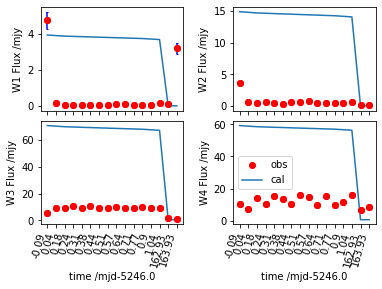

In [ ]:
tjd = np.loadtxt(f'mba.jd.{name}')
tmjd = tjd-2450000.5
roundmjd = np.around(tmjd,0)
rmjd = min(roundmjd)
print(rmjd)
xtime = np.around(tmjd-rmjd,2)
yflux = Model_neatm_Ref_jhx(test,xt,lamdai)
plt.subplot(2,2,1)
plt.plot(y[:n4],'ro',label='obs')
plt.errorbar(range(0,n4,1),y[:n4], yerr=y[:n4]*0.1, fmt="o",ecolor='b',color='r', capsize=1.0)
plt.plot(yflux[:n4],label='cal')
plt.xticks(range(0,n4,1),xtime,rotation=75,ha='right')
#plt.xlabel('time /mjd')
plt.ylabel('W1 Flux /mjy')
ax1 = plt.gca()
ax1.axes.xaxis.set_ticklabels([])

plt.subplot(2,2,2)
plt.plot(y[n4:n4*2],'ro',label='obs')
plt.errorbar(range(0,n4,1),y[n4:n4*2], yerr=y[n4:n4*2]*0.1, fmt="o",ecolor='b',color='r', capsize=1.0)
plt.plot(yflux[n4:n4*2],label='cal')
plt.xticks(range(0,n4,1),xtime,rotation=75,ha='right')
#plt.xlabel('time /mjd')
plt.ylabel('W2 Flux /mjy')
ax2 = plt.gca()
ax2.axes.xaxis.set_ticklabels([])

plt.subplot(2,2,3)
plt.plot(y[n4*2:n4*3],'ro',label='obs')
plt.errorbar(range(0,n4,1),y[n4*2:n4*3], yerr=y[n4*2:n4*3]*0.1, fmt="o",ecolor='b',color='r', capsize=1.0)
plt.plot(yflux[n4*2:n4*3],label='cal')
plt.xticks(range(0,n4,1),xtime,rotation=75,ha='right')
plt.xlabel(f'time /mjd-{rmjd}')
plt.ylabel('W3 Flux /mjy')

plt.subplot(2,2,4)
plt.plot(y[n4*3:],'ro',label='obs')
plt.errorbar(range(0,n4,1),y[n4*3:], yerr=y[n4*3:]*0.1, fmt="o",ecolor='b',color='r', capsize=1.0)
plt.plot(yflux[n4*3:],label='cal')
plt.xticks(range(0,n4,1),xtime,rotation=75,ha='right')
plt.xlabel(f'time /mjd-{rmjd}')
plt.ylabel('W4 Flux /mjy')
plt.legend()
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.35,hspace=0.1)
print(len(tjd),n4)